In [15]:
import gurobipy as gp
from gurobipy import GRB
from dataclasses import dataclass
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

rng = np.random.default_rng(seed=42)

In [5]:
@dataclass
class KPCustomer:
    n: int
    utils: np.ndarray
    prices: np.ndarray
    capacity: int
    solution: np.ndarray

    def __init__(self, utils: np.ndarray, prices: np.ndarray, capacity: int, solution: np.ndarray):
        self.utils = utils
        self.prices = prices
        self.capacity = capacity
        self.solution = solution
        self.n = len(utils)


def solve_kp(utils: np.ndarray, prices: np.ndarray, capacity: int) -> np.ndarray:
    env = gp.Env()
    env.setParam("OutputFlag", 0)
    m = gp.Model("SimpleKP", env=env)
    x = m.addMVar(len(utils), vtype=GRB.BINARY, name="x")
    m.setObjective(x @ utils, GRB.MAXIMIZE)
    m.addConstr(x @ prices <= capacity)
    m.optimize()
    return x.X


def generate_dataset(num_goods: int, num_cust: int, util_price_corr=True) -> list[KPCustomer]:
    customers = []
    utils = rng.integers(1, 1001, size=num_goods)
    norm_utils = utils / np.linalg.norm(utils, 1)

    for _ in range(num_cust):
        price_var = rng.integers(-10, 11, size=num_goods)
        if util_price_corr:
            prices = utils + 100 + price_var
        else:
            prices = 100 + price_var
        capacity = rng.integers(1, np.sum(prices))

        solution = solve_kp(norm_utils, prices, capacity)
        customers.append(KPCustomer(norm_utils, prices, capacity, solution))
    return customers


In [17]:
data = generate_dataset(num_goods=50, num_cust=200)
utils = data[0].utils

Set parameter Username
Academic license - for non-commercial use only - expires 2024-12-09
Set parameter Username
Academic license - for non-commercial use only - expires 2024-12-09
Set parameter Username
Academic license - for non-commercial use only - expires 2024-12-09
Set parameter Username
Academic license - for non-commercial use only - expires 2024-12-09
Set parameter Username
Academic license - for non-commercial use only - expires 2024-12-09
Set parameter Username
Academic license - for non-commercial use only - expires 2024-12-09
Set parameter Username
Academic license - for non-commercial use only - expires 2024-12-09
Set parameter Username
Academic license - for non-commercial use only - expires 2024-12-09
Set parameter Username
Academic license - for non-commercial use only - expires 2024-12-09
Set parameter Username
Academic license - for non-commercial use only - expires 2024-12-09
Set parameter Username
Academic license - for non-commercial use only - expires 2024-12-09

ValueError: zero-dimensional arrays cannot be concatenated

In [30]:
X = np.concatenate([[cust.solution] for cust in data], axis=0)
y = np.array([cust.solution @ cust.utils for cust in data])
lm = LinearRegression(fit_intercept=False, positive=True)
lm.fit(X, y)
print(lm.coef_)
print(utils)
print(np.linalg.norm(utils - lm.coef_, 1))

[0.02303929 0.         0.02544579 0.01735837 0.0048919  0.00844248
 0.03081111 0.03617642 0.02004103 0.03854347 0.0071406  0.01183525
 0.03672874 0.00694335 0.02603756 0.00867919 0.01309768 0.0188575
 0.0142023  0.03451949 0.03838567 0.01976487 0.02075114 0.00220925
 0.00927095 0.         0.03380937 0.00899479 0.01345274 0.03325706
 0.0281679  0.02453843 0.         0.02221083 0.02213192 0.01258482
 0.02939088 0.03668929 0.01025722 0.01309768 0.01274262 0.03294145
 0.         0.03534796 0.03061386 0.01909421 0.02303929 0.03530851
 0.03037715 0.01092788]
[0.02303929 0.00165694 0.02544579 0.01735837 0.0048919  0.00844248
 0.03081111 0.03617642 0.02004103 0.03854347 0.0071406  0.01183525
 0.03672874 0.00694335 0.02603756 0.00867919 0.01309768 0.0188575
 0.0142023  0.03451949 0.03838567 0.01976487 0.02075114 0.00220925
 0.00927095 0.00157803 0.03380937 0.00899479 0.01345274 0.03325706
 0.0281679  0.02453843 0.00153858 0.02221083 0.02213192 0.01258482
 0.02939088 0.03668929 0.01025722 0.0130

In [11]:
# Offline algorithm
def offline_inverse_kp(customers: list) -> np.ndarray:
    n = customers[0].n
    utils = customers[0].utils
    T = len(customers)

    env = gp.Env()
    env.setParam("OutputFlag", 0)
    m = gp.Model("Offline Inverse KP", env=env)
    c = m.addMVar(n, name="c")
    y = m.addMVar(T, name="y")

    m.setObjective(gp.quicksum(customer.capacity * y[t] - c @ customer.solution
        for t, customer in enumerate(customers)))

    m.addConstr(gp.quicksum(c) >= 0)
    m.addConstr(gp.quicksum(c) <= 1)

    for t, customer in enumerate(customers):
        m.addConstrs(customer.prices[i] * y[i] >= c[i] for i in range(n))
        m.addConstr(y[t] >= 0)

    m.optimize()
    print(c.X)
    print(utils)
    return c.X

In [31]:
# Online algorithms
def mwu(customers: list) -> list:
    n = customers[0].n
    T = len(customers)
    lr = np.sqrt(np.log(n)/T)
    weights = [np.ones(n)]
    costs = []
    x = []
    y = []
    for customer in customers:
        costs.append((weights[-1] / np.linalg.norm(weights[-1], 1)).flatten())
        x.append(solve_kp(costs[-1], customer.prices, customer.capacity))
        if (x[-1] == customer.solution).all():
            y.append(0)
        else:
            y.append((x[-1] - customer.solution) / np.linalg.norm(x[-1] - customer.solution, np.inf))
        weights.append(weights[-1] - lr * (weights[-1] * y[-1]))
    return costs

In [32]:
costs = mwu(data)
# utils = offline_inverse_kp(data)

Set parameter Username
Academic license - for non-commercial use only - expires 2024-12-09
Set parameter Username
Academic license - for non-commercial use only - expires 2024-12-09
Set parameter Username
Academic license - for non-commercial use only - expires 2024-12-09
Set parameter Username
Academic license - for non-commercial use only - expires 2024-12-09
Set parameter Username
Academic license - for non-commercial use only - expires 2024-12-09
Set parameter Username
Academic license - for non-commercial use only - expires 2024-12-09
Set parameter Username
Academic license - for non-commercial use only - expires 2024-12-09
Set parameter Username
Academic license - for non-commercial use only - expires 2024-12-09
Set parameter Username
Academic license - for non-commercial use only - expires 2024-12-09
Set parameter Username
Academic license - for non-commercial use only - expires 2024-12-09
Set parameter Username
Academic license - for non-commercial use only - expires 2024-12-09

0.12413454447384696


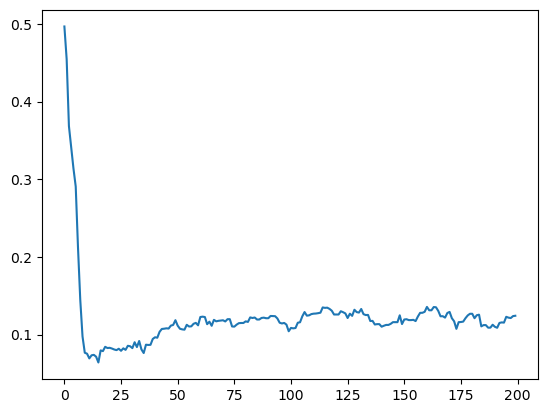

In [33]:
utils = data[0].utils
error = [np.linalg.norm(utils - cost, 1) for cost in costs]
print(error[-1])
plt.plot(error)